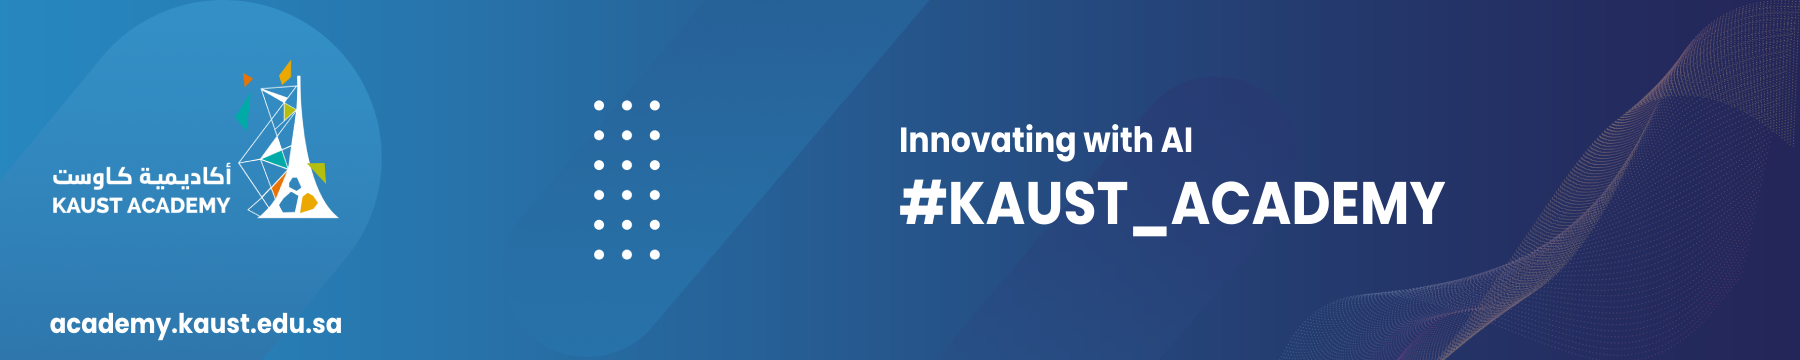

This notebook has been inspired from [Actor Critic Example](https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py) and [actor_critic](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb#scrollTo=-mJ2i6jvZ3sK).

# Actor Critic

In this notebook, we will implementa basic Actor Critic Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Actor Critic Methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.




### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

Due to the usage of this advantage function, this algorithm is also **Advantage Actor Critic (A2C)**.
<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


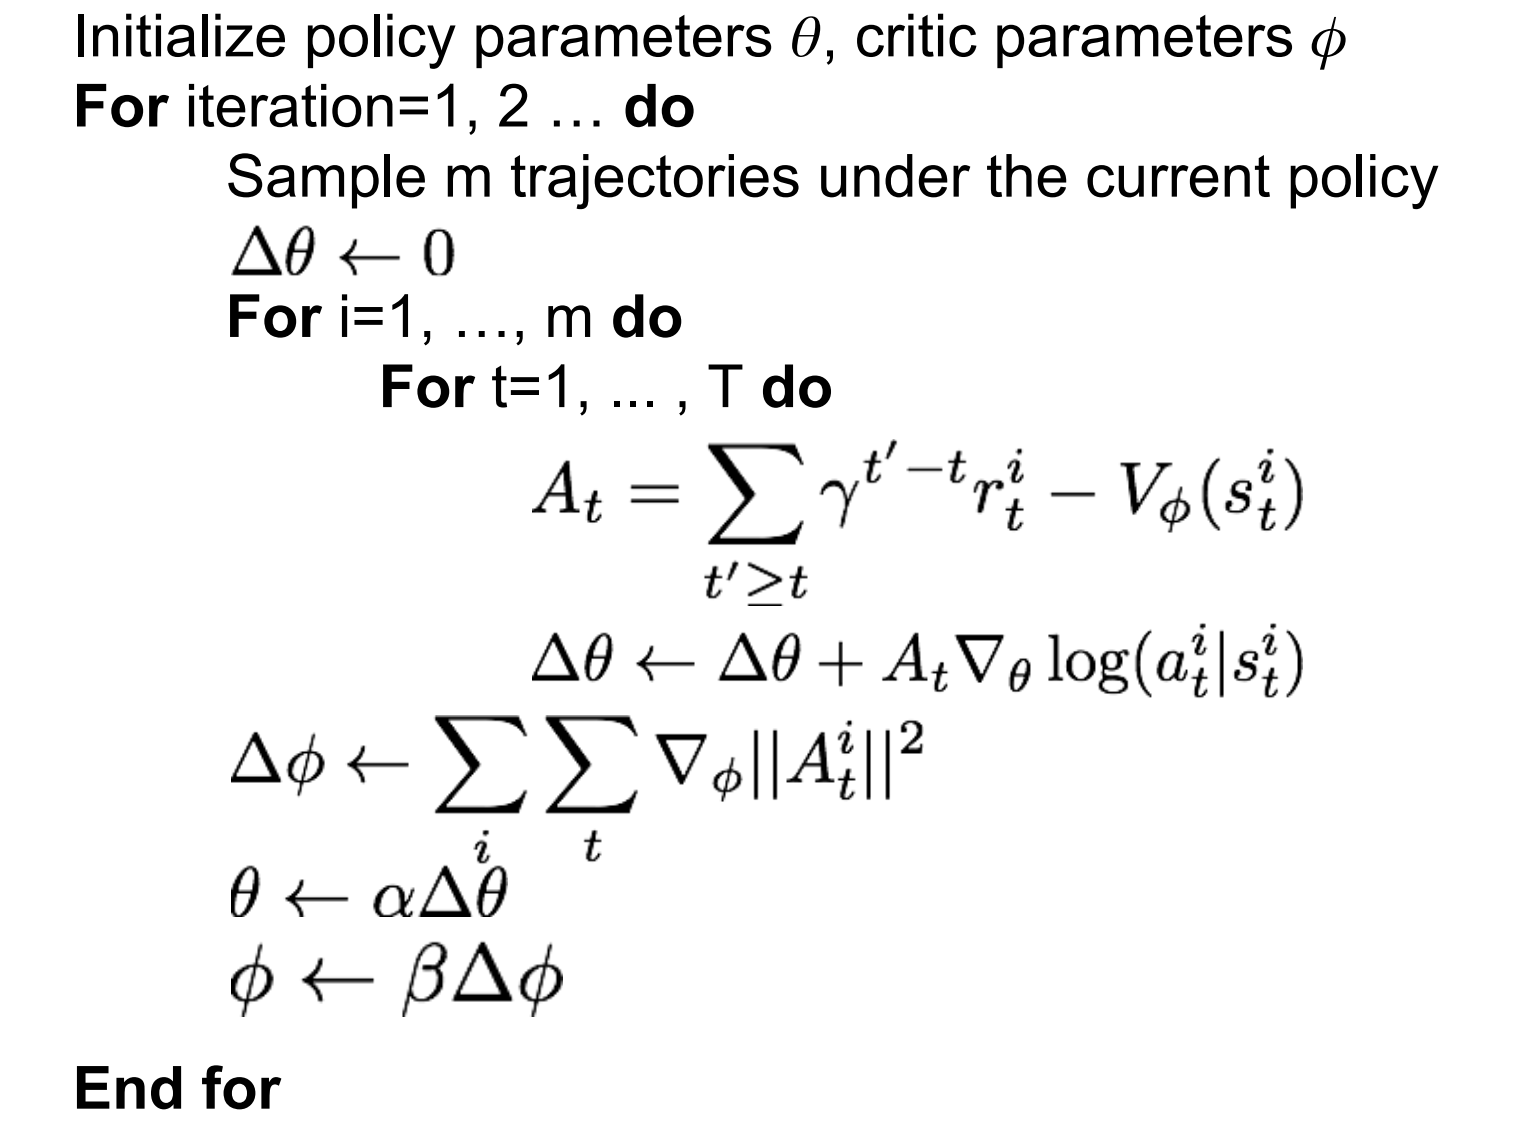

[Image Source](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf)

In [ ]:
%pip install swig
%pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379368 sha256=a0a43ec971c185a8906df58a50297663830ba41f16aeed11f56854557b066be7
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

### Actor Critic Network

In [ ]:
class ActorCritic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(n_observations, 128)

        # actor's layer
        self.action_head = nn.Linear(128, n_actions)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        # create a categorical distribution over the list of probabilities of actions
        m = Categorical(probs)
        # and sample an action using the distribution
        action = m.sample()
        return action.item(), m.log_prob(action), state_value.squeeze(0)

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 500              # Max steps per episode
learning_rate = 1e-2         # Learning rate|
gamma = 0.99                 # Discounting rate

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize policy network
actor_critic = ActorCritic(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

In [ ]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state, _ = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = actor_critic.act(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    rewards.append(reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  # Back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -115.46502576976155
Episode 2: Reward = -277.6744044673387
Episode 3: Reward = -196.6066388118424
Episode 4: Reward = -554.7530976091716
Episode 5: Reward = -115.17716057468809
Episode 6: Reward = -247.60873970282822
Episode 7: Reward = -114.87709766133715
Episode 8: Reward = -77.01295477036847
Episode 9: Reward = -79.85648314707805
Episode 10: Reward = -126.90111072531633
Episode 11: Reward = -167.45641930364604
Episode 12: Reward = -142.33770851729594
Episode 13: Reward = -92.13293670664775
Episode 14: Reward = -117.84743422282202
Episode 15: Reward = -87.23994076142786
Episode 16: Reward = -99.524320084086
Episode 17: Reward = -214.7371194307145
Episode 18: Reward = -106.05701655744248
Episode 19: Reward = -138.72997871778858
Episode 20: Reward = -181.15923935839254
Episode 21: Reward = -152.8763824952744
Episode 22: Reward = -223.41039081545284
Episode 23: Reward = -304.98311408486086
Episode 24: Reward = -152.35976010674278
Episode 25: Reward = -165.46910800326

Text(0, 0.5, 'Reward')

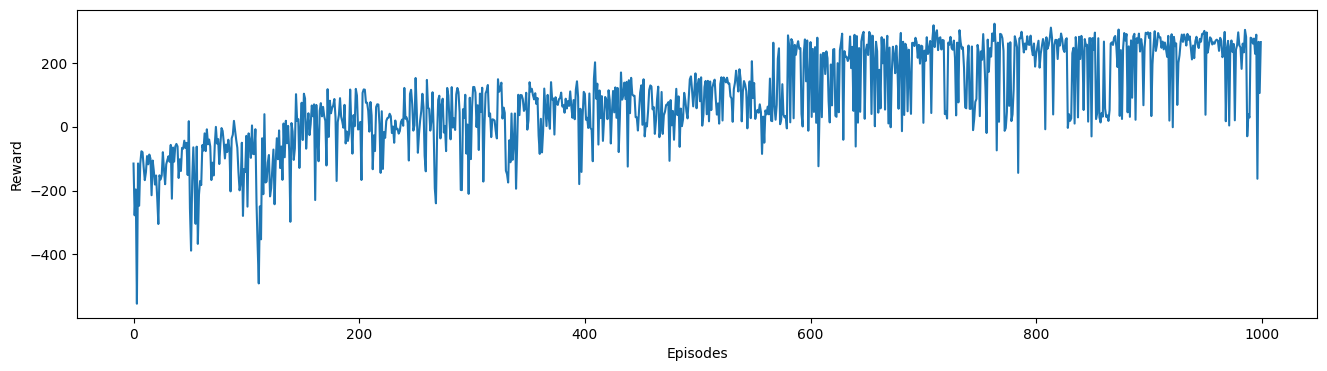

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = actor_critic.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
show_video("LunarLander-v2")